# Example: The retinal model system

In this tutorial, we demonstrate how to load and analyze surface hopping trajectory data for a retinal model system. 

Our goal is to illustrate a full workflow: importing trajectories, performing essential post-processing, and extracting three key reaction coordinates, which have been identified to comprehensively describe the photoinduced $S_0\rightarrow~S_1$ relaxation and the *cis/trans*-isomerization around the carbon-carbon double bond:

- a **torsion angle** around the central carbon-carbon double bond ($\varphi_{\text{C-C=C-C}}$),
- the **bond-length alternation (BLA)** of the full chromophore, and
- the **out-of-plane movement of the hydrogens (HOOP)** that are connected to the isomerizing C=C bond.

By the end of this guide, you will be able to compute these features from trajectory data and use them for mechanistic interpretation or downstream machine-learning applications.



In [1]:
import pandas as pd
import seaborn as sns

import shnitsel as st

#specific code for plotting within this tutorial
import plots_retinal as pr

## 1) Import and preparation of data
### 1.1) Loading data

In [2]:
dt = st.io.read('tut_data/traj_I02.nc', kind='shnitsel')
dt

<xarray.DataTree 'ROOT'>
Group: /
│   Attributes:
│       DataTree_Level:  ShnitselDBRoot
└── Group: /I02
    │   Attributes:
    │       DataTree_Level:  CompoundGroup
    │       compound_info:   {'compound_name': 'I02'}
    ├── Group: /I02/0
    │       Dimensions:              (time: 384, state: 3, atom: 14, direction: 3,
    │                                 statecomb: 3, full_statecomb: 6)
    │       Coordinates: (12/15)
    │         * time                 (time) float64 3kB 0.0 0.5 1.0 ... 190.5 191.0 191.5
    │         * state                (state) int64 24B 1 2 3
    │         * atom                 (atom) int64 112B 0 1 2 3 4 5 6 7 8 9 10 11 12 13
    │         * direction            (direction) <U1 12B 'x' 'y' 'z'
    │         * statecomb            (statecomb) object 24B MultiIndex
    │         * full_statecomb       (full_statecomb) object 48B MultiIndex
    │           ...                   ...
    │           atNames              (atom) <U1 56B ...
    │           atNums               (atom) int64 112B ...
    │         * from                 (statecomb) int64 24B 1 1 2
    │         * to                   (statecomb) int64 24B 2 3 3
    │         * full_statecomb_from  (full_statecomb) int64 48B 1 1 2 2 3 3
    │         * full_statecomb_to    (full_statecomb) int64 48B 2 3 1 3 1 2
    │       Data variables:
    │           energy               (time, state) float32 5kB ...
    │           forces               (time, state, atom, direction) float32 194kB ...
    │           atXYZ                (time, atom, direction) float32 65kB ...
    │           dip_perm             (time, state, direction) float32 14kB ...
    │           dip_trans            (time, statecomb, direction) float32 14kB ...
    │           socs                 (time, full_statecomb) complex128 37kB ...
    │           astate               (time) int32 2kB ...
    │           sdiag                (time) int32 2kB ...
    │           phases               (time, state) float32 5kB ...
    │       Attributes: (12/15)
    │           input_format:           sharc
    │           t_max:                  1000.0
    │           delta_t:                0.5
    │           max_ts:                 384
    │           completed:              False
    │           input_type:             dynamic
    │           ...                     ...
    │           num_triplets:           0
    │           has_forces:             True
    │           misc_input_settings:    {'input': {'printlevel': '2', 'geomfile': '"geom"...
    │           trajectory_input_path:  retinal_tutorial/I02/TRAJ_00001
    │           trajid:                 1
    │           DataTree_Level:         TrajectoryData
    ├── Group: /I02/1
    │       Dimensions:              (time: 367, state: 3, atom: 14, direction: 3,
    │                                 statecomb: 3, full_statecomb: 6)
    │       Coordinates: (12/15)
    │         * time                 (time) float64 3kB 0.0 0.5 1.0 ... 182.0 182.5 183.0
    │         * state                (state) int64 24B 1 2 3
    │         * atom                 (atom) int64 112B 0 1 2 3 4 5 6 7 8 9 10 11 12 13
    │         * direction            (direction) <U1 12B 'x' 'y' 'z'
    │         * statecomb            (statecomb) object 24B MultiIndex
    │         * full_statecomb       (full_statecomb) object 48B MultiIndex
    │           ...                   ...
    │           atNames              (atom) <U1 56B ...
    │           atNums               (atom) int64 112B ...
    │         * from                 (statecomb) int64 24B 1 1 2
    │         * to                   (statecomb) int64 24B 2 3 3
    │         * full_statecomb_from  (full_statecomb) int64 48B 1 1 2 2 3 3
    │         * full_statecomb_to    (full_statecomb) int64 48B 2 3 1 3 1 2
    │       Data variables:
    │           energy               (time, state) float32 4kB ...
    │           forces               (time, state, atom, direction) float32 185kB ...
    │   

## 1.2) Preparing the data

For pre-processing, we herein only slice out the dataset from the datatree and assign a mol object to the dataset.

In [3]:
from shnitsel.data.tree import tree_to_frames

ds = tree_to_frames(dt['I02'])
mol = st.bridges.to_mol(ds.atXYZ.isel(frame=0), charge=1)
ds.attrs['mol'] = mol
ds.atXYZ.attrs['mol'] = mol
ds

<xarray.Dataset> Size: 6MB
Dimensions:                (state: 3, frame: 6452, atom: 14, direction: 3,
                            statecomb: 3, full_statecomb: 6, trajid_: 16)
Coordinates: (12/24)
  * state                  (state) int64 24B 1 2 3
  * frame                  (frame) object 52kB MultiIndex
  * atom                   (atom) int64 112B 0 1 2 3 4 5 6 7 8 9 10 11 12 13
  * direction              (direction) <U1 12B 'x' 'y' 'z'
  * statecomb              (statecomb) object 24B MultiIndex
  * full_statecomb         (full_statecomb) object 48B MultiIndex
    ...                     ...
    input_format           (trajid_) <U5 320B 'sharc' 'sharc' ... 'sharc'
    t_max                  (trajid_) float64 128B 1e+03 1e+03 ... 1e+03 1e+03
    max_ts                 (trajid_) int64 128B 384 367 444 106 ... 449 335 439
    completed              (trajid_) bool 16B False False False ... False False
    has_forces             (trajid_) bool 16B True True True ... True True True
    trajectory_input_path  (trajid_) <U31 2kB 'retinal_tutorial/I02/TRAJ_0000...
Data variables:
    energy                 (state, frame) float32 77kB -248.2 -248.2 ... -248.0
    forces                 (state, atom, direction, frame) float32 3MB 0.0200...
    atXYZ                  (atom, direction, frame) float32 1MB -4.182 ... 2.009
    dip_perm               (state, direction, frame) float32 232kB 6.736 ... ...
    dip_trans              (statecomb, direction, frame) float32 232kB -6.596...
    socs                   (full_statecomb, frame) complex128 619kB 0j 0j ... 0j
    astate                 (frame) int32 26kB 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1
    sdiag                  (frame) int32 26kB 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1
    phases                 (state, frame) float32 77kB -1.0 1.0 1.0 ... 1.0 1.0
Attributes:
    num_triplets:          0
    delta_t:               0.5
    num_singlets:          3
    num_doublets:          0
    input_type:            dynamic
    input_format_version:  3.0
    mol:                   <rdkit.Chem.rdchem.Mol object at 0x7f6c77bdb5a0>

## 2) Computing Descriptors from Internal Coordinates

In the next step, we **flag selected internal coordinates of a molecule**. Flagging identifies which bonds, bond angles, and dihedral angles are considered active for subsequent analysis.

The flagging procedure returns dictionaries of internal coordinates (keys: `'bonds'`, `'angles'`, and `'dihedrals'`), where only those belonging to a specified substructure are marked as active. Substructures can be defined either by SMARTS patterns or by explicit tuples of atom indices.
If no substructure is specified, the entire molecule is flagged, yielding all intrinsic coordinates.

In a subsequent step, the resulting dictionaries are passed to the geocalc module, which computes the corresponding geometric properties from XYZ structures along the trajectories.

## 2.1) Selecting Internal Coordinates

There ate two main strategies to select internal coordinates of interest for further processing:

If only specific internal coordinates are required, individual bonds (minimum 2 atoms), bond angles (minimum 3 atoms), or torsion angles (minimum 4 atoms) can be flagged directly using the functions provided in `shnitsel.geo.geomatch`.

<details>
<summary><strong>Example: flagging C=C double bonds</strong></summary>
<br>
The following example flags all C=C double bonds in a molecule:
<br>

```python
from shnitsel.geo.geomatch import flag_bonds
d_flag, img = flag_bonds(mol, smarts='C=C', draw=True)
```
</details>
<br>

When bonds, bond angles, and torsions of a specific molecular region are of interest, the `shnitsel.geo.geomatch.flag_bats` function can be used. Substructures can be specified either by atom indices or by SMARTS patterns.

<details>
<summary><strong>Example: Flagging bonds, angles and torsions</strong></summary>
<br>
Example for flagging the torsion angle around the central C=C double bond using only carbon atoms, using a tuple of atom indices:
<br>

```python
from shnitsel.geo.geomatch import flag_bats
idxs_phi1 = (3,5,7,9)
d_flag, img_flag = flag_bats(mol, t_idxs=idxs_phi1, draw=True)
```
<br>
Same as above, using SMARTS:

```python
from shnitsel.geo.geomatch import flag_bats
smarts_phi1 = '[#6;D3]C=C[#6;D3]'
d_flag, img_flag = flag_bats(mol, smarts=smarts_phi1, draw=True)
```
</details>
<br>

In the following, we employ the `flag_bats_multiple` function, to account for the three geometric features of interest. These include:

- a **torsion angle** around the central carbon-carbon double bond ($\varphi_{\text{C-C=C-C}}$),
- the **bond-length alternation (BLA)** of the full chromophore, and
- the **out-of-plane movement of the hydrogens (HOOP)** that are connected to the isomerizing C=C bond

These features are defined by flagging the central CC=CC and corresponding HC=CH torsion angles, as well as the chromophore with alternating single and double bonds, using three distinct SMARTS patterns.

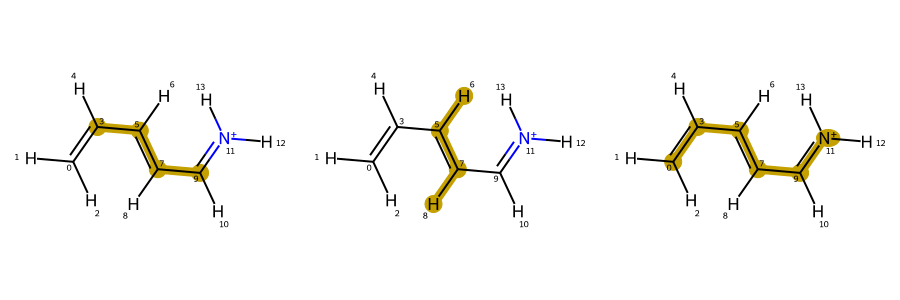

In [4]:
from shnitsel.geo.geomatch import flag_bats_multiple

smarts_phi1 = '[#6;D3]C=C[#6;D3]'
smarts_phi2 = '[#1][#6;D3;H1]=[#6;D3;H1][#1]'
smarts_bla = '[#6,#7]=[#6][#6]=[#6][#6]=[#6,#7]'

d_flag, img = flag_bats_multiple(mol, l_smarts=[smarts_phi1, smarts_phi2, smarts_bla], draw=True)
img

From the PCA plot, we can support that there are actually trajectories that isomerize:

INFO: Dimension atomcomb is being generated.
INFO: Dimension atomcomb is being generated.


sweeping clock from -40°
swept to -90°
sweeping anti from 40°
swept to 120°


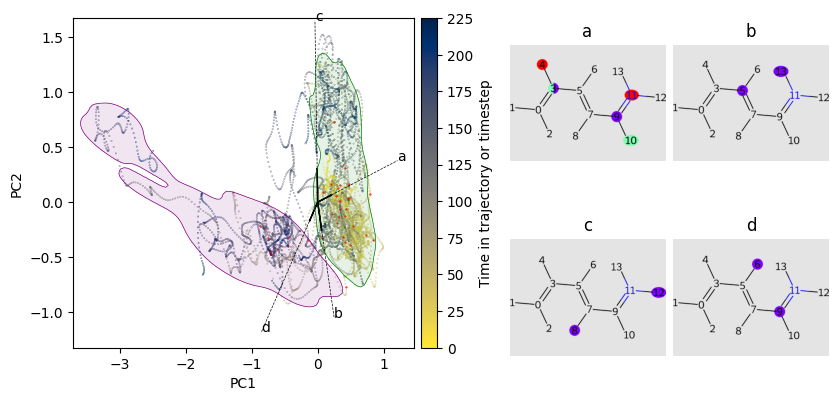

In [5]:
from shnitsel.vis.plot import biplot_kde

kde_data = biplot_kde(ds, 3,5,7,9)

## 2.2) Computing the Descriptors

After flagging the relevant internal coordinates, the corresponding geometric descriptors (bond lengths, bond angles, and torsion angles) are computed directly from the molecular geometries.

The values are obtained using the functions provided in `shnitsel.geo.geocalc`, with the previously generated flag dictionaries defining which internal coordinates are evaluated. This separation of coordinate selection and value computation enables a flexible and modular workflow.

In [6]:
from shnitsel.geo.geocalc import get_bond_torsions, get_bla_chromophor

# compute tagged torsion angles
arr_phi1 = get_bond_torsions(ds.atXYZ, d_flag[smarts_phi1], ang='deg', signed=False).values.reshape(-1)
arr_phi2 = get_bond_torsions(ds.atXYZ, d_flag[smarts_phi2], ang='deg', signed=False).values.reshape(-1)

# compute HOOP by subtracting phi2 from phi1 for every data point
arr_hoop = (arr_phi1 - arr_phi2)

# compute BLA for tagged chromophor
arr_bla = get_bla_chromophor(ds.atXYZ, d_flag[smarts_bla]).values.reshape(-1)

Now, we combine information on the times, active states, identifiers, energies in $S_0$ and S$_1$ and the respective energy gap with the three descriptors in a pandas.DataFrame for plotting purposes.

In [7]:
df_all = pd.DataFrame(
    {'time': ds.time.values,
     'astate': ds.astate.values,
     'trajid': ds.trajid.values,
     'E_S0': ds.energy.values[0,:],
     'E_S1': ds.energy.values[1,:],
     'gap': ds.energy.values[1,:]-ds.energy.values[0,:],
     "dihedral": arr_phi1,
     "HOOP": arr_hoop,
     "BLA": arr_bla})

df_all.head(n=3)

,time,astate,trajid,E_S0,E_S1,gap,dihedral,HOOP,BLA
0,0.0,2,1,-248.220673,-248.048676,0.171997,171.923721,1.129089,0.109977
1,0.5,2,1,-248.227158,-248.054443,0.172714,171.794388,2.127426,0.109505
2,1.0,2,1,-248.234207,-248.060715,0.173492,171.670013,2.994812,0.106802


First, we plot the change of the S$_1$-$S_0$ energy gap, the BLA and HOOP descriptor over time (color coded by the central dihedral).
By comparing e.g. trajectory #1 and #9 it is apparent, that isomerization occurs only in trajectory #1.

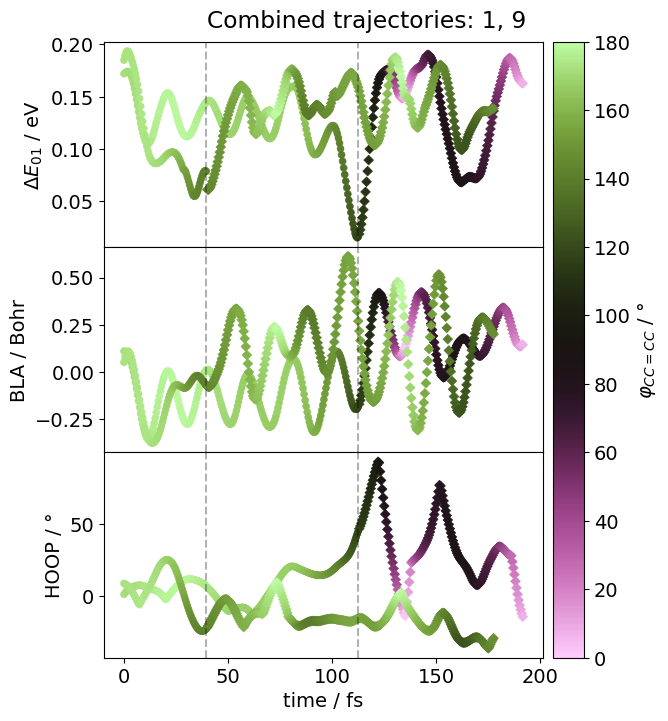

In [8]:
pr.plot_stack(df_all, trajid_list=[1,9])

To pin this finding into a structural reason, we align the trajectories to the time of the last $S_1\rightarrow{}S_0$ hop.
From this visualization it is clearly apparent, that the difference in reaction outcome can be associated with the HOOP motion, which goes towards negative values in case of no isomerization but positive values for the isomerizing case (trajectory #1).

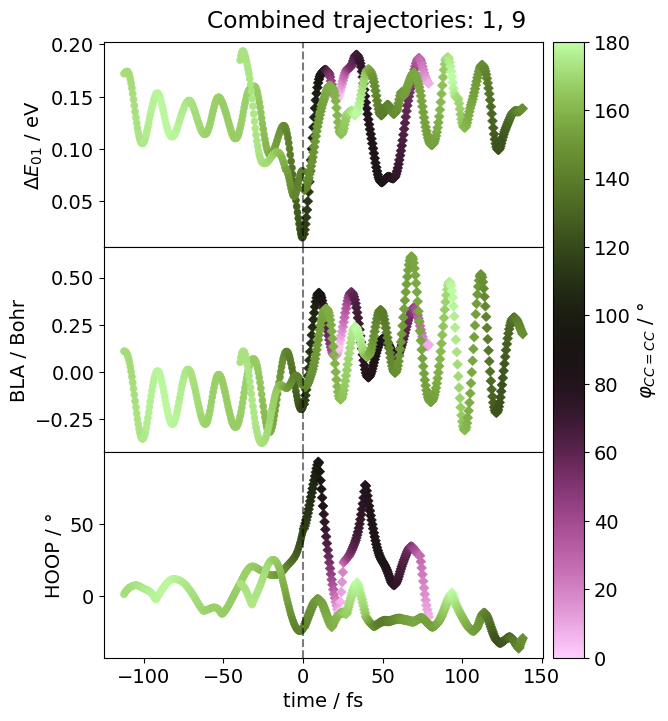

In [9]:
df_all_aligned, hop_times = pr.align_trajectories_to_last_hop(df_all, from_state=2, to_state=1)
pr.plot_stack(df_all_aligned, time='time_aligned', trajid_list=[1,9])

Now we can inspect the pairwise correlations between the key properties at the last $S_1 \rightarrow S_0$ hopping point to evaluate whether our conclusions hold across the dataset.

To do this, we first assign labels to each trajectory based on its final dihedral angle, indicating whether it underwent isomerization. We then extract the data corresponding to the hopping points and plot the pairwise relationships using a pairplot. From this visualization, it becomes clear that in most trajectories where no isomerization occurs, the HOOP angle remains near zero, while the central torsion angle stays between 100° and 180°.

In [10]:
df_hops = pr.label_trajectory(df_all_aligned, lower_bound=70, upper_bound=110)
df_hops_plot = pr.get_last_hops_from_states(df_hops)
df_hops_plot.head(n=15)

,time,astate,trajid,E_S0,E_S1,gap,dihedral,HOOP,BLA,time_aligned,isomerization
0,112.5,2,1,-248.100677,-248.084488,0.016190,118.044289,45.020866,-0.185651,0.0,E-to-Z
1,161.5,2,2,-248.087341,-248.082367,0.004974,83.430557,2.756500,0.046169,0.0,E-to-Z
2,66.0,2,3,-248.075256,-248.064560,0.010696,130.554916,72.597061,0.049063,0.0,E-to-E
3,64.0,2,6,-248.048813,-248.038803,0.010010,166.753174,15.741623,0.079057,0.0,E-to-E
4,98.0,2,8,-248.107056,-248.104065,0.002991,97.239510,6.913269,-0.081910,0.0,E-to-E
5,39.5,2,9,-248.119263,-248.040588,0.078674,141.966629,-22.696182,-0.070333,0.0,E-to-E
6,84.5,2,10,-248.079407,-248.072235,0.007172,164.428223,14.919983,-0.137161,0.0,E-to-E
7,41.5,2,12,-248.097290,-248.061386,0.035904,133.707275,73.121811,-0.048259,0.0,E-to-Z
8,124.5,2,14,-248.114624,-248.083755,0.030869,62.861401,-24.482121,-0.104214,0.0,E-to-Z
9,213.5,2,17,-248.103714,-248.092773,0.010941,77.781578,-37.248589,-0.103370,0.0,undetermined


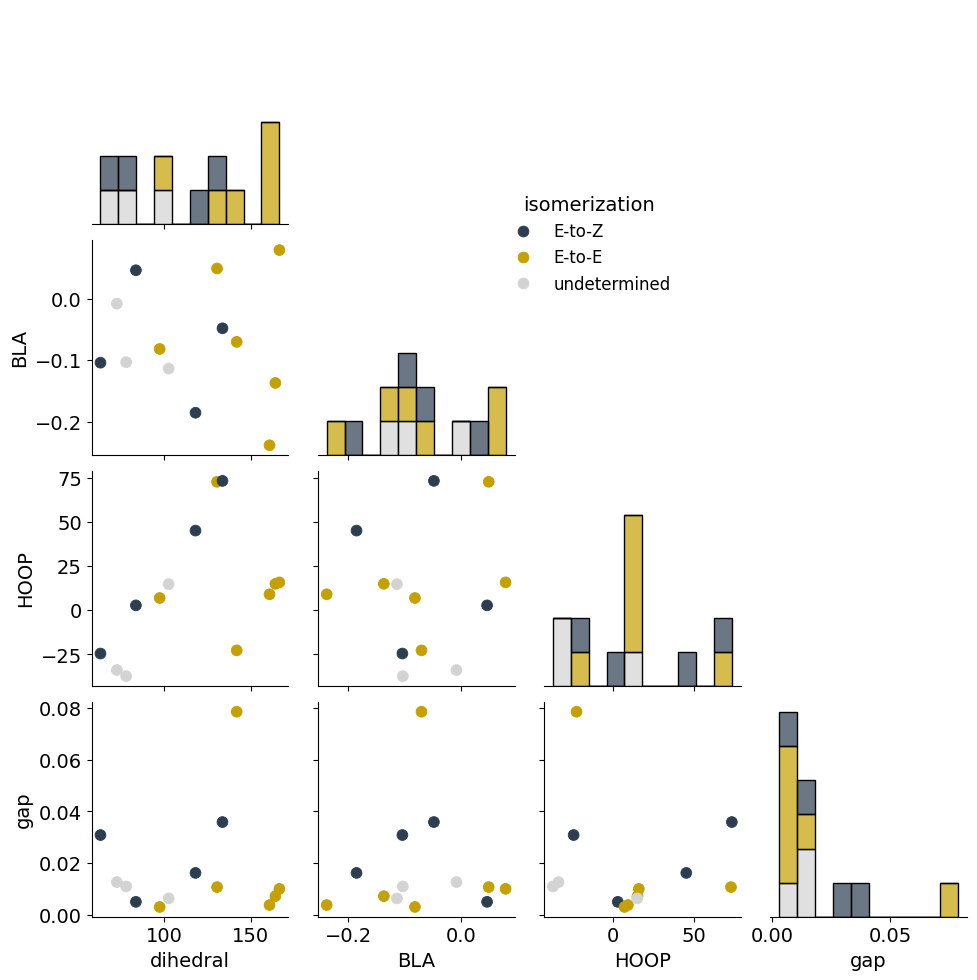

In [11]:
# pairplot
st_blue = (44/255, 62/255, 80/255)
st_yellow = (196/255, 160/255, 0/255)

g = sns.pairplot(
    df_hops_plot,
    vars=["dihedral", "BLA", "HOOP", "gap"],
    hue="isomerization",
    palette={"E-to-Z": st_blue, "E-to-E": st_yellow, 'undetermined': 'lightgray'},
    diag_kind='hist', diag_kws={'multiple':'stack', 'alpha':0.7, 'bins':10},
    plot_kws={"s": 60, "edgecolor": None, "alpha": 1},
    corner=True,
)

g._legend.set_bbox_to_anchor((0.5, 0.8))
g._legend.set_loc('upper center')